# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import haversine_distances
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train_hw2.csv')
train.sample(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
59954,id2534143,1,2016-06-21 10:42:21,2016-06-21 10:54:17,1,-73.968964,40.790840,-73.962234,40.813686,N,716
540335,id2562024,2,2016-03-05 14:25:40,2016-03-05 14:34:55,1,-73.987602,40.733101,-73.970154,40.755180,N,555
1125513,id2892072,2,2016-01-20 12:11:37,2016-01-20 12:29:27,5,-74.000847,40.731800,-73.997429,40.719219,N,1070
1175599,id2490231,1,2016-03-29 23:42:04,2016-03-29 23:56:24,1,-73.872902,40.774208,-73.949387,40.806110,N,860
479085,id2185431,1,2016-03-16 15:41:31,2016-03-16 15:56:05,1,-73.995392,40.752174,-74.003494,40.719067,N,874


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
del train['dropoff_datetime']
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

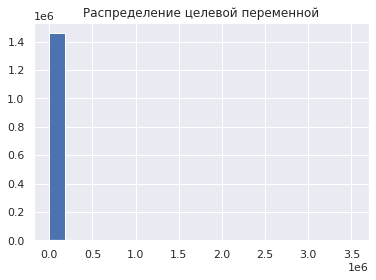

In [ ]:
plt.hist(train['trip_duration'], bins=20)
plt.title('Распределение целевой переменной')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

In [ ]:
train['trip_duration'].sort_values(ascending=False).head(10)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64

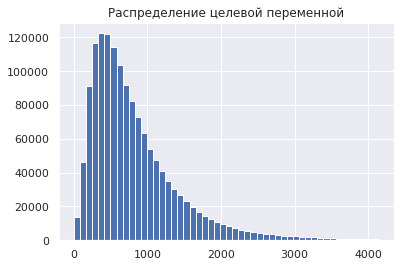

In [ ]:
plt.hist(train['trip_duration'],
         bins=50,
         range=(train['trip_duration'].min(),
                train['trip_duration'].quantile(.995)))
plt.title('Распределение целевой переменной')
plt.show()

**Ответ** : Если не учитывать выбросы, то распределение можно считать логнормальным. Значения длительности поездки > 80000 секунд - выбросы, так как вряд ли из одной точки Нью-Йорка в другую можно добираться в течение суток

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: В данных есть выбросы, а метрика RMSLE не учитывает масштаб данных, поэтому будет меньше штрафовать за ошибки на больших числах, чем MSE.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:

$a(x_i) = \exp(\hat{a}(x_i)) - 1$

$\hat{y}_i = \log{(y_i + 1)}$

$\hat{a}_i = \log{(a(x_i) + 1)}$

$ MSE(\hat{y}_i,\hat{a}_i) = \frac{1}{l} \sum_{i=1}^{l}  (\hat{a}(x_i) - \hat{y_i}) = \frac{1}{l} \sum_{i=1}^{l} (\log{(a(x_i) + 1)} - \log{(y_i + 1)}) $

$ RMSLE({y}_i,{a}_i) = \sqrt{\frac{1}{l} \sum_{i=1}^{l} (\log(y_i + 1) - \log(a(x_i) + 1))^2}$ 

Получается, что $ RMSLE({y}_i,{a}_i) = \sqrt{MSE(\hat{y}_i,\hat{a}_i)} $
Так как $ MSE>=0 $ и корень - монотонно возрастающая функция ($x_1 < x_2 \Leftrightarrow \sqrt{x_1} < \sqrt{x_2}$), то минимизация $ RMSLE({y}_i,{a}_i) $ равносильна минимизации $ MSE(\hat{y}_i,\hat{a}_i) $

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [ ]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])
del train['trip_duration']

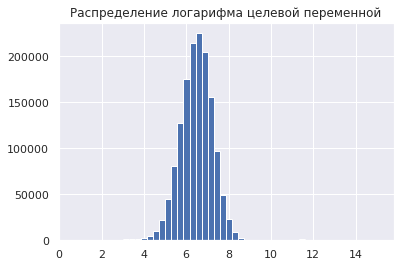

In [ ]:
plt.hist(train['log_trip_duration'], bins=50)
plt.title('Распределение логарифма целевой переменной')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
# лучшее константное предсказание - среднее значение
best_const_preds = [np.mean(train['log_trip_duration'])] * len(train)
print(
    f"RMSE: {mean_squared_error(train['log_trip_duration'],best_const_preds,squared=False):.5f}"
)

RMSE: 0.79576


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [ ]:
train['pickup_date'] = train['pickup_datetime'].dt.date
days = sorted(train['pickup_date'].unique())

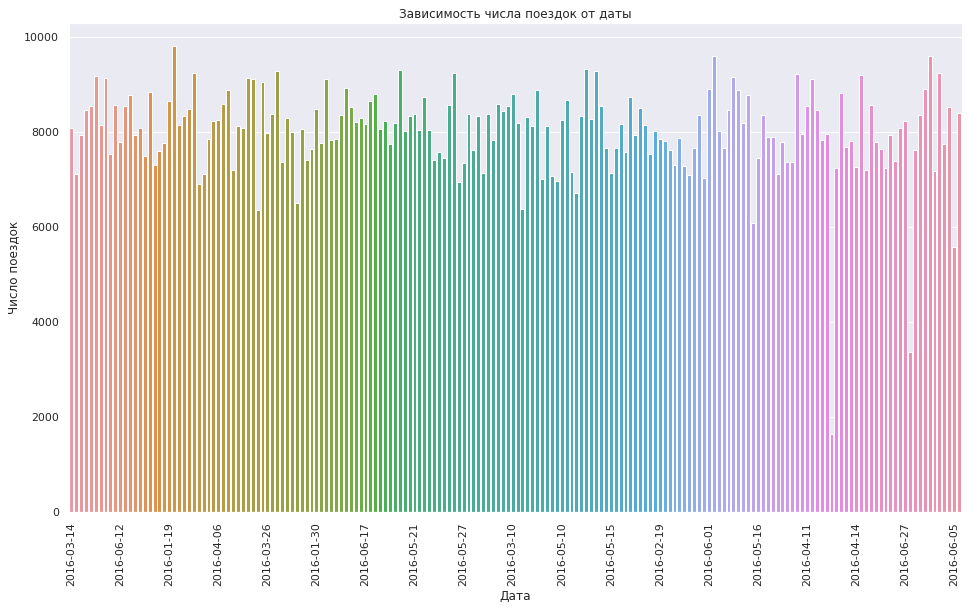

In [ ]:
plt.figure(figsize=(16, 9))
sns.countplot(x='pickup_date', data=train)
plt.title('Зависимость числа поездок от даты')
plt.xlabel('Дата')
plt.xticks(range(0, len(days), 10), rotation='vertical')
plt.ylabel('Число поездок')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
train.groupby('pickup_date')['id'].count().sort_values().head()

pickup_date
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
Name: id, dtype: int64

*   23-24 января из-за снегопада [ограничили](https://ria.ru/20160124/1364582768.html) движение машин
*   30 мая - [день поминовения](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BD%D1%8C_%D0%BF%D0%BE%D0%BC%D0%B8%D0%BD%D0%BE%D0%B2%D0%B5%D0%BD%D0%B8%D1%8F_(%D0%A1%D0%A8%D0%90))



In [ ]:
train['pickup_hour'] = train['pickup_datetime'].dt.hour
count_hour = train.groupby('pickup_hour', as_index=False)['id'].count()

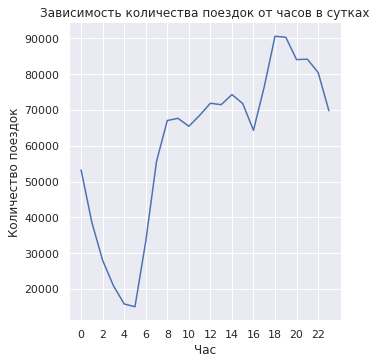

In [ ]:
sns.relplot(x='pickup_hour', y='id', kind='line', data=count_hour)
plt.title('Зависимость количества поездок от часов в сутках')
plt.xlabel('Час')
plt.xticks(range(0, 24, 2))
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
days_of_week = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]

train['pickup_weekday'] = train['pickup_datetime'].dt.day_name()
train['pickup_weekday'] = pd.Categorical(train['pickup_weekday'],
                                         categories=days_of_week,
                                         ordered=True)
count_wd = train.groupby('pickup_weekday', as_index=False)['id'].count()

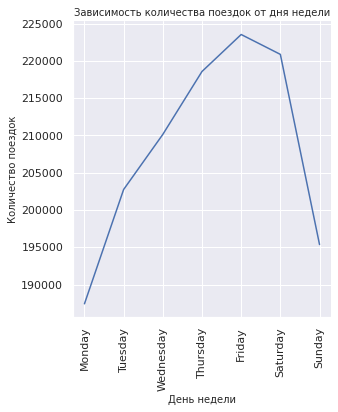

In [ ]:
sns.relplot(x='pickup_weekday', y='id', kind='line', data=count_wd)
plt.title('Зависимость количества поездок от дня недели', fontsize=10)
plt.xlabel('День недели', fontsize=10)
plt.xticks(rotation='vertical')
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [ ]:
train['pickup_month'] = train['pickup_datetime'].dt.month_name()
conth_month_hour = train.groupby(['pickup_month', 'pickup_hour'],
                                 as_index=False)['id'].count()

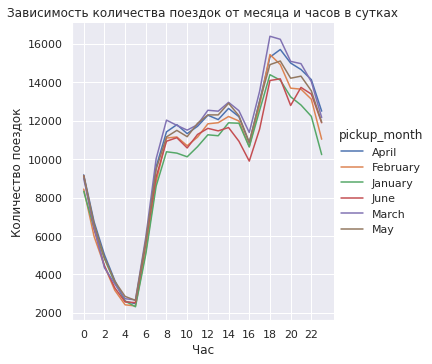

In [ ]:
sns.relplot(x='pickup_hour',
            y='id',
            hue='pickup_month',
            kind='line',
            data=conth_month_hour)
plt.title('Зависимость количества поездок от месяца и часов в сутках')
plt.xlabel('Час')
plt.xticks(range(0, 24, 2))
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
count_weekday_hour = train.groupby(['pickup_weekday', 'pickup_hour'],
                                   as_index=False)['id'].count()

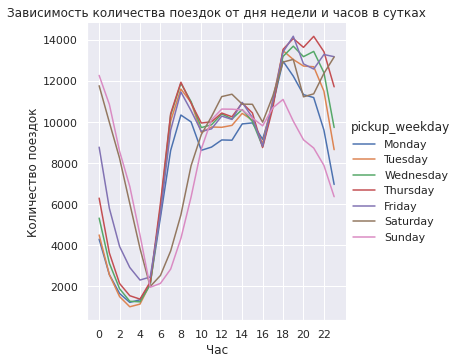

In [ ]:
sns.relplot(x='pickup_hour',
            y='id',
            hue='pickup_weekday',
            kind='line',
            data=count_weekday_hour)
plt.title('Зависимость количества поездок от дня недели и часов в сутках')
plt.xlabel('Час')
plt.xticks(range(0, 24, 2))
plt.ylabel('Количество поездок')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: 
*   В пятницу и субботу самое большое количество поездок, в понедельник и воскресенье - самое маленькое
*   Ночью количество поездок минимальное, максимальное - вечером, когда люди возвращаются с работы
*   Количество поездок не зависит от месяца



**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
train['pickup_dayofyear'] = train['pickup_datetime'].dt.dayofyear

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns='log_trip_duration'),
    train['log_trip_duration'].values,
    test_size=0.3,
    random_state=42,
    shuffle=True)

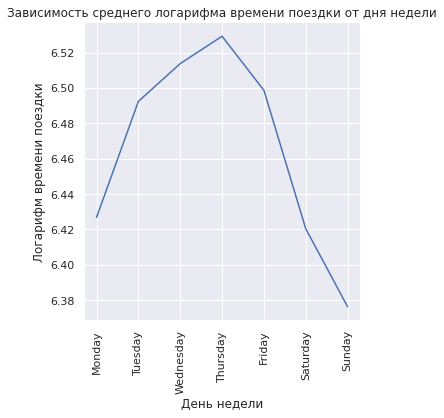

In [ ]:
sns.relplot(x=X_train['pickup_weekday'],
            y=y_train,
            kind='line',
            err_style=None)
plt.title('Зависимость среднего логарифма времени поездки от дня недели')
plt.xlabel('День недели')
plt.xticks(rotation='vertical')
plt.ylabel('Логарифм времени поездки')
plt.show()

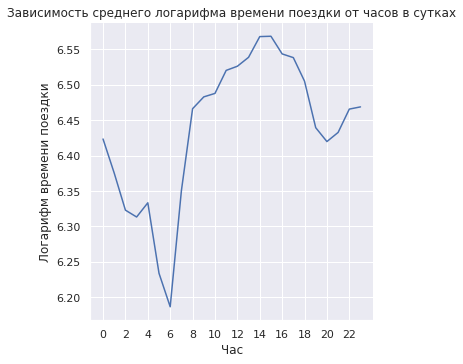

In [ ]:
sns.relplot(x=X_train['pickup_hour'], y=y_train, kind='line', err_style=None)
plt.title('Зависимость среднего логарифма времени поездки от часов в сутках')
plt.xlabel('Час')
plt.xticks(range(0, 24, 2))
plt.ylabel('Логарифм времени поездки')
plt.show()

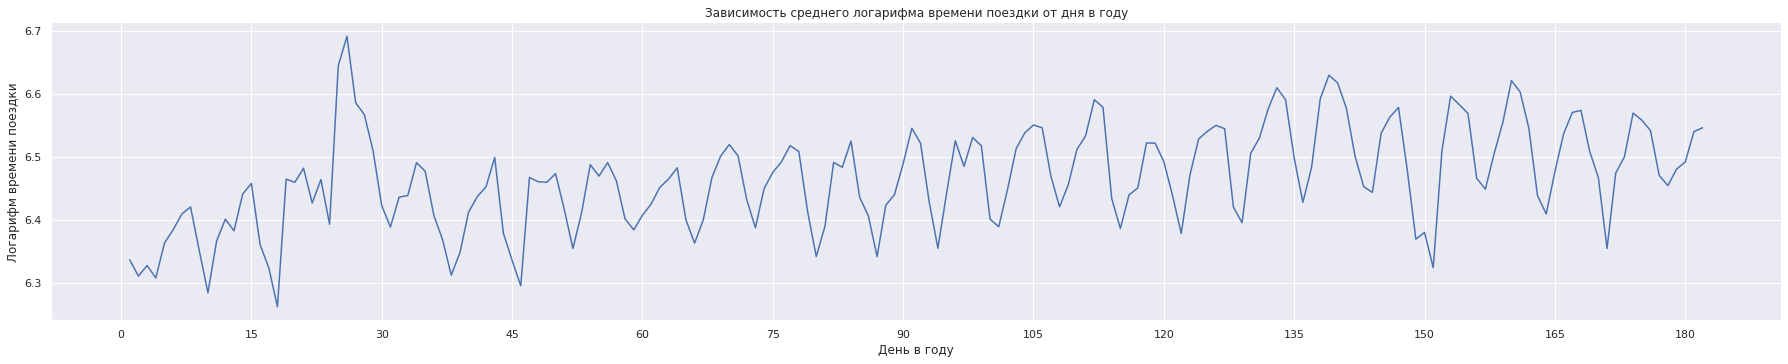

In [ ]:
sns.relplot(x=X_train['pickup_dayofyear'],
            y=y_train,
            kind='line',
            err_style=None,
            height=5,
            aspect=5)
plt.title('Зависимость среднего логарифма времени поездки от дня в году')
plt.xlabel('День в году')
plt.xticks(range(0, 182, 15))
plt.ylabel('Логарифм времени поездки')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: 

*   Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? В целом похожи, разве что максимум и минимум на графике для дня недели достигается в разные дни, максимум на графике для часа в сутках достигается в разное время
*   Почему? Когда увеличивается количество поездок, увеличивается и количество машин на дорогах => появляются пробки и увеличивается время поездки
*   Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? 23-24 января время поездки самое большое на всей обучающей выборки, так как в то время был снегопад, логично, что были и сильные пробки.
5 июня - среднее время - одно из наименьших на всей обучающей выборке
*  Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году? Нет, только возможен небольшой рост


Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
train.groupby('pickup_date')['id'].count().sort_values().head()

pickup_date
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
Name: id, dtype: int64

In [ ]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_month'] = train['pickup_datetime'].dt.month

train['is_anomal_1'] = np.where(
    train['pickup_date'].isin(
        train.groupby('pickup_date')['id'].count().sort_values().head(
            2).index.tolist()), 1, 0)
train['is_anomal_2'] = (train['pickup_date'] == datetime.date(2016, 5,
                                                              30)).astype(int)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: все выделенные признаки стоит рассматривать как категориальные, так как на них нельзя ввести отношения порядка

In [ ]:
cat_features = [
    'pickup_hour', 'pickup_weekday', 'pickup_month', 'pickup_dayofyear'
]
bin_features = ['is_anomal_1', 'is_anomal_2']
num_features = []
features = cat_features + bin_features + num_features

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns='log_trip_duration'),
    train['log_trip_duration'].values,
    test_size=0.3,
    random_state=42,
    shuffle=True)

In [ ]:
def preprocess(train, test, cat_features, num_features, features):
    train = pd.get_dummies(train[features], columns=cat_features)
    test = pd.get_dummies(test[features], columns=cat_features)

    if num_features:
        train[num_features] = scaler.fit_transform(train[num_features])
        test[num_features] = scaler.transform(test[num_features])

    return train, test


def get_result(train, test, y_train, y_test, cat_features, num_features,
               features):
    train, test = preprocess(train, test, cat_features, num_features, features)
    model = Ridge()
    model.fit(train, y_train)
    preds = model.predict(test)
    err = mean_squared_error(y_test, preds, squared=False)
    return f"RMSE: {np.round(err,5)}"

In [ ]:
print(
    get_result(X_train, X_test, y_train, y_test, cat_features, num_features,
               features))

RMSE: 0.78713


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(radius=100,
                      location=(row[latitude_column], row[longitude_column]),
                      color=color,
                      fill_color=color,
                      fill=True).add_to(m)

    return m

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude",
                    "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude",
                    "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Аэропорты

1.   John F. Kennedy Intrenational Airport
2.   Newark Liberty International Airport



**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(
        lat * 0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5)**2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
X_train.loc[:, 'haversine_distance'] = (haversine_array(
    X_train['pickup_latitude'].values, X_train['pickup_longitude'].values,
    X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values))

X_test.loc[:, 'haversine_distance'] = (haversine_array(
    X_test['pickup_latitude'].values, X_test['pickup_longitude'].values,
    X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values))

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [ ]:
X_train['log_haversine_distance'] = np.log1p(X_train['haversine_distance'])
X_test['log_haversine_distance'] = np.log1p(X_test['haversine_distance'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
print(
    f"Корреляция расстояния и таргета:{np.corrcoef(X_train['haversine_distance'],y_train)[0,1]:.5f}"
)
print(
    f"Корреляция логарифма расстояния и таргета:{np.corrcoef(X_train['log_haversine_distance'],y_train)[0,1]:.5f}"
)

Корреляция расстояния и таргета:0.56541
Корреляция логарифма расстояния и таргета:0.74996


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
X_train['speed'] = X_train['haversine_distance'] / np.expm1(y_train)

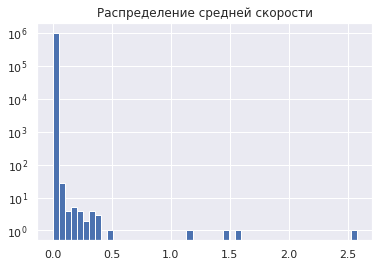

In [ ]:
plt.hist(X_train['speed'], bins=50)
plt.title('Распределение средней скорости')
plt.yscale('log')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

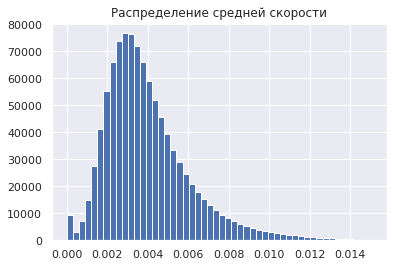

In [ ]:
plt.hist(X_train['speed'],
         bins=50,
         range=(X_train['speed'].min(), X_train['speed'].quantile(.999)))
plt.title('Распределение средней скорости')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [ ]:
med_weekday = X_train.groupby('pickup_weekday',
                              as_index=False)['speed'].median()
med_hour = X_train.groupby('pickup_hour', as_index=False)['speed'].median()
med_wd_hour = X_train.groupby(['pickup_weekday', 'pickup_hour'],
                              as_index=False)['speed'].median()

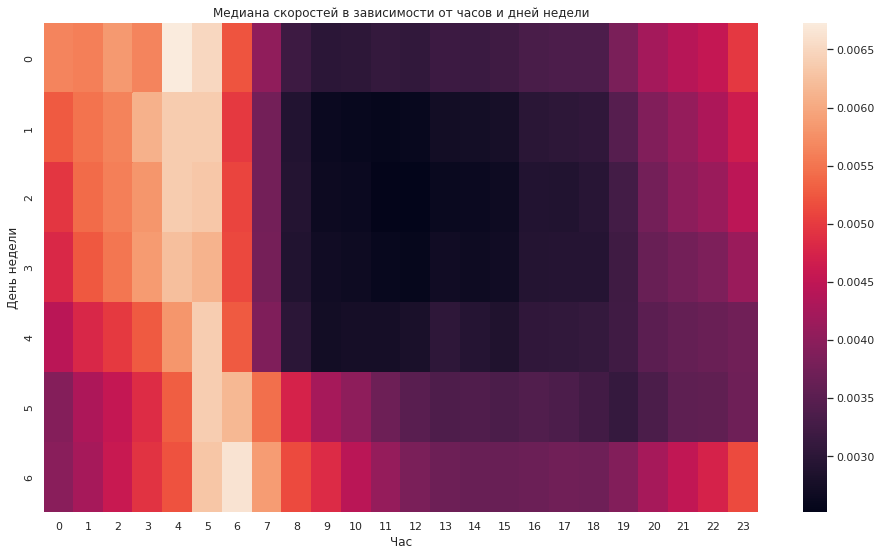

In [ ]:
plt.figure(figsize=(16, 9))
sns.heatmap(med_wd_hour.pivot('pickup_weekday', 'pickup_hour', 'speed'))
plt.title('Медиана скоростей в зависимости от часов и дней недели')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Так как этот признак посчитан с использованием целевой переменной => будет утечка

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

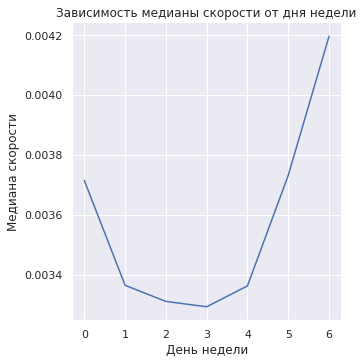

In [ ]:
sns.relplot(x='pickup_weekday',
            y='speed',
            data=med_weekday,
            kind='line',
            err_style=None)
plt.title('Зависимость медианы скорости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Медиана скорости')
plt.show()

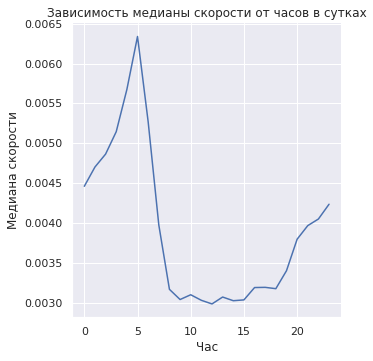

In [ ]:
sns.relplot(x='pickup_hour',
            y='speed',
            data=med_hour,
            kind='line',
            err_style=None)
plt.title('Зависимость медианы скорости от часов в сутках')
plt.xlabel('Час')
plt.ylabel('Медиана скорости')
plt.show()

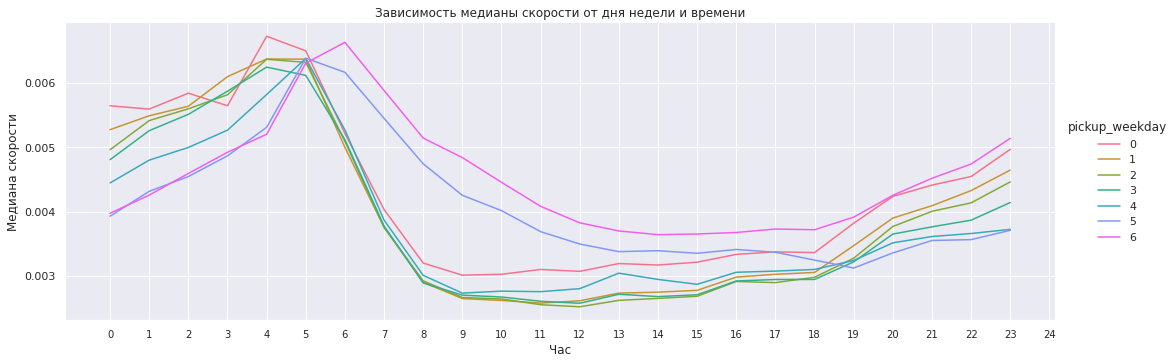

In [ ]:
sns.relplot(x='pickup_hour',
            y='speed',
            hue='pickup_weekday',
            data=med_wd_hour,
            kind='line',
            err_style=None,
            palette=sns.color_palette("husl", 7),
            aspect=3)
plt.title('Зависимость медианы скорости от дня недели и времени')
plt.xticks(range(0, 25), fontsize=10)
plt.xlabel('Час')
plt.ylabel('Медиана скорости')
plt.show()

Свободные дороги - с 3 до 5 утра, пробки с 9 до 19 в будние дни

In [ ]:
X_train['is_free'] = 0
X_test['is_free'] = 0
X_train.loc[(X_train['pickup_hour'] >= 3) & (X_train['pickup_hour'] < 6),
            'is_free'] = 1
X_test.loc[(X_test['pickup_hour'] >= 3) & (X_test['pickup_hour'] < 6),
           'is_free'] = 1

In [ ]:
X_train['jams'] = 0
X_test['jams'] = 0
X_train.loc[(X_train['pickup_hour'] >= 9) & (X_train['pickup_hour'] < 19) &
            (X_train['pickup_weekday'] < 5), 'jams'] = 1
X_test.loc[(X_test['pickup_hour'] >= 9) & (X_test['pickup_hour'] < 19) &
           (X_test['pickup_weekday'] < 5), 'jams'] = 1

In [ ]:
del X_train['speed']

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [ ]:
kennedy_coords = [40.61, 40.67, -73.81, -73.75]
liberty_coords = [40.66, 40.72, -74.21, -74.15]

In [ ]:
def set_airport(df, feature, coords, start=True):
    if start:
        df.loc[(df['pickup_latitude'] >= coords[0]) &
               (df['pickup_latitude'] <= coords[1]) &
               (df['pickup_longitude'] >= coords[2]) &
               (df['pickup_longitude'] <= coords[3]),
               f"started_in_{feature}"] = 1
        df[f"started_in_{feature}"] = df[f"started_in_{feature}"].fillna(
            0).astype(int)
    else:
        df.loc[(df['dropoff_latitude'] >= coords[0]) &
               (df['dropoff_latitude'] <= coords[1]) &
               (df['dropoff_longitude'] >= coords[2]) &
               (df['dropoff_longitude'] <= coords[3]),
               f"ended_in_{feature}"] = 1
        df[f"ended_in_{feature}"] = df[f"ended_in_{feature}"].fillna(0).astype(
            int)
    return df

In [ ]:
X_train = set_airport(X_train,
                      feature='kennedy_airport',
                      coords=kennedy_coords)
X_test = set_airport(X_test, feature='kennedy_airport', coords=kennedy_coords)

X_train = set_airport(X_train,
                      feature='kennedy_airport',
                      coords=kennedy_coords,
                      start=False)
X_test = set_airport(X_test,
                     feature='kennedy_airport',
                     coords=kennedy_coords,
                     start=False)

X_train = set_airport(X_train,
                      feature='liberty_airport',
                      coords=kennedy_coords)
X_test = set_airport(X_test, feature='liberty_airport', coords=kennedy_coords)

X_train = set_airport(X_train,
                      feature='liberty_airport',
                      coords=kennedy_coords,
                      start=False)
X_test = set_airport(X_test,
                     feature='liberty_airport',
                     coords=kennedy_coords,
                     start=False)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

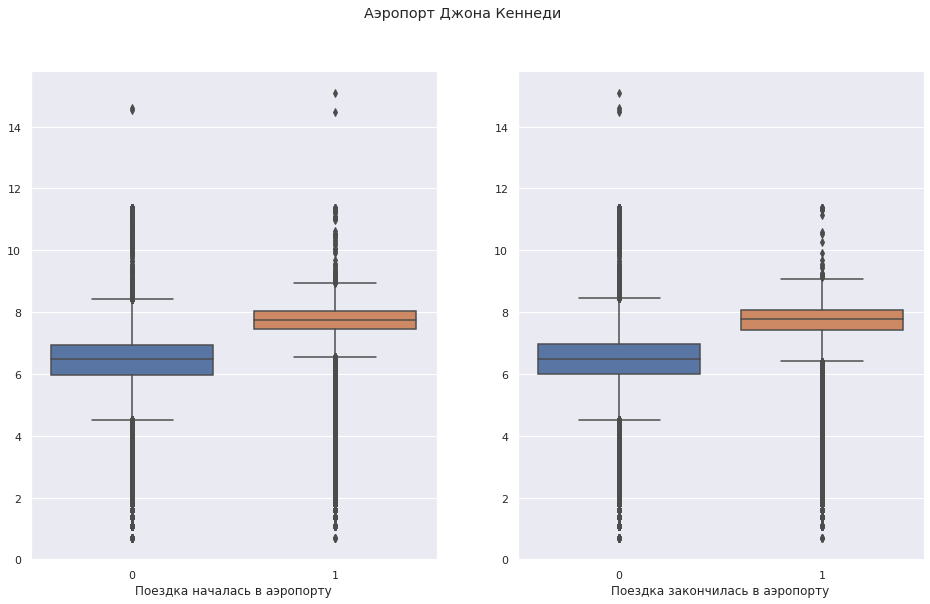

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.boxplot(x=X_train['started_in_kennedy_airport'], y=y_train, ax=ax[0])
sns.boxplot(x=X_train['ended_in_kennedy_airport'], y=y_train, ax=ax[1])
ax[0].set_xlabel('Поездка началась в аэропорту')
ax[1].set_xlabel('Поездка закончилась в аэропорту')
plt.suptitle('Аэропорт Джона Кеннеди')
plt.show()

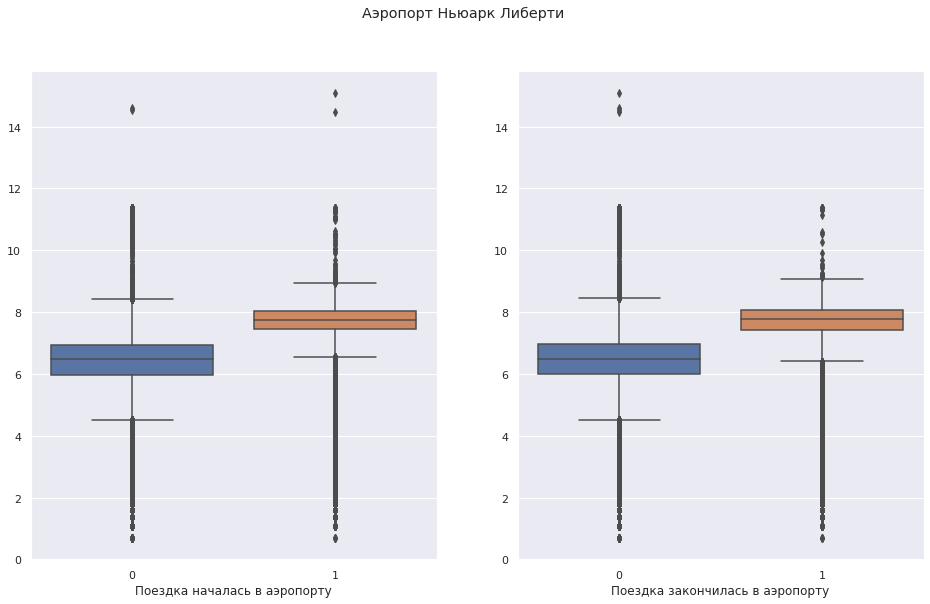

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.boxplot(x=X_train['started_in_liberty_airport'], y=y_train, ax=ax[0])
sns.boxplot(x=X_train['ended_in_liberty_airport'], y=y_train, ax=ax[1])
ax[0].set_xlabel('Поездка началась в аэропорту')
ax[1].set_xlabel('Поездка закончилась в аэропорту')
plt.suptitle('Аэропорт Ньюарк Либерти')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: Да. Видно, что время поездки, где конечная или начальная точка - аэропорт больше, чем обычно

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=4, n_cols=3):
        lat = [40.705, 40.786]
        lon = [-74.016, -73.936]
        self.max_lat = max(lat)
        self.max_lon = max(lon)
        self.min_lat = min(lat)
        self.min_lon = min(lon)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.lat_scaler = (self.max_lat - self.min_lat) / self.n_rows
        self.lon_scaler = (self.max_lon - self.min_lon) / self.n_cols

    def fit_transform(self, X):
        X.loc[(X['pickup_longitude'] > self.max_lon) |
              (X['pickup_longitude'] < self.min_lon) |
              (X['pickup_latitude'] > self.max_lat) |
              (X['pickup_latitude'] < self.min_lat), 'pickup'] = -1
        X.loc[(X['dropoff_longitude'] > self.max_lon) |
              (X['dropoff_longitude'] < self.min_lon) |
              (X['dropoff_latitude'] > self.max_lat) |
              (X['dropoff_latitude'] < self.min_lat), 'dropoff'] = -1
        for i in range(1, self.n_rows + 1):
            for j in range(1, self.n_cols + 1):
                lat_start = self.min_lat + self.lat_scaler * (i - 1)
                lat_end = self.min_lat + self.lat_scaler * (i)
                lon_start = self.min_lon + self.lon_scaler * (j - 1)
                lon_end = self.min_lon + self.lon_scaler * (j)
                X.loc[(X['pickup_latitude'] >= lat_start) &
                      (X['pickup_latitude'] < lat_end) &
                      (X['pickup_longitude'] >= lon_start) &
                      (X['pickup_longitude'] < lon_end),
                      'pickup'] = (i - 1) * self.n_cols + j
                X.loc[(X['dropoff_latitude'] >= lat_start) &
                      (X['dropoff_latitude'] < lat_end) &
                      (X['dropoff_longitude'] >= lon_start) &
                      (X['dropoff_longitude'] < lon_end),
                      'dropoff'] = (i - 1) * self.n_cols + j
        return X

In [ ]:
mapgrid = MapGridTransformer(6, 6)
X_train = mapgrid.fit_transform(X_train)
X_test = mapgrid.fit_transform(X_test)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
cat_features = [
    'pickup_hour', 'pickup_weekday', 'pickup', 'dropoff', 'pickup_month',
    'pickup_dayofyear'
]
bin_features = [
    'is_anomal_1', 'is_anomal_2', 'is_free', 'jams',
    'started_in_kennedy_airport', 'ended_in_kennedy_airport',
    'started_in_liberty_airport', 'ended_in_liberty_airport'
]
num_features = ['log_haversine_distance']
features = cat_features + bin_features + num_features

In [ ]:
print(
    get_result(X_train, X_test, y_train, y_test, cat_features, num_features,
               features))

RMSE: 0.4722


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.


*   vendor_id - у разных аггрегаторов может быть разное количество и состояние машин
*   passenger_count - могли сесть вместе, но конечная точка разная
*   store_and_fwd_flag - если данные не отправились сразу, возможно, что был плохой интеренет => маршрут мог проходить за городом



Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
print(f"vendor_id : {X_train['vendor_id'].nunique()}")
print(f"passenger_count : {X_train['passenger_count'].nunique()}")
print(f"store_and_fwd_flag : {X_train['store_and_fwd_flag'].nunique()}")

vendor_id : 2
passenger_count : 10
store_and_fwd_flag : 2


In [ ]:
display(X_train['vendor_id'].value_counts())
display(X_train['passenger_count'].value_counts())
display(X_train['store_and_fwd_flag'].value_counts())

2    546566
1    474484
Name: vendor_id, dtype: int64

1    723614
2    147429
5     54532
3     41919
6     33707
4     19804
0        41
7         2
8         1
9         1
Name: passenger_count, dtype: int64

N    1015403
Y       5647
Name: store_and_fwd_flag, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

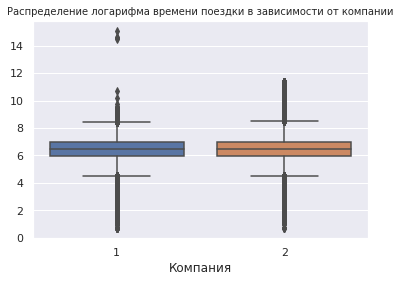

In [ ]:
sns.boxplot(x=X_train['vendor_id'], y=y_train)
plt.title('Распределение логарифма времени поездки в зависимости от компании',
          fontsize=10)
plt.xlabel('Компания')
plt.show()

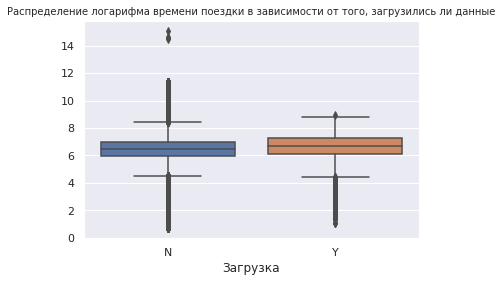

In [ ]:
sns.boxplot(x=X_train['store_and_fwd_flag'], y=y_train)
plt.title(
    'Распределение логарифма времени поездки в зависимости от того, загрузились ли данные',
    fontsize=10)
plt.xlabel('Загрузка')
plt.show()

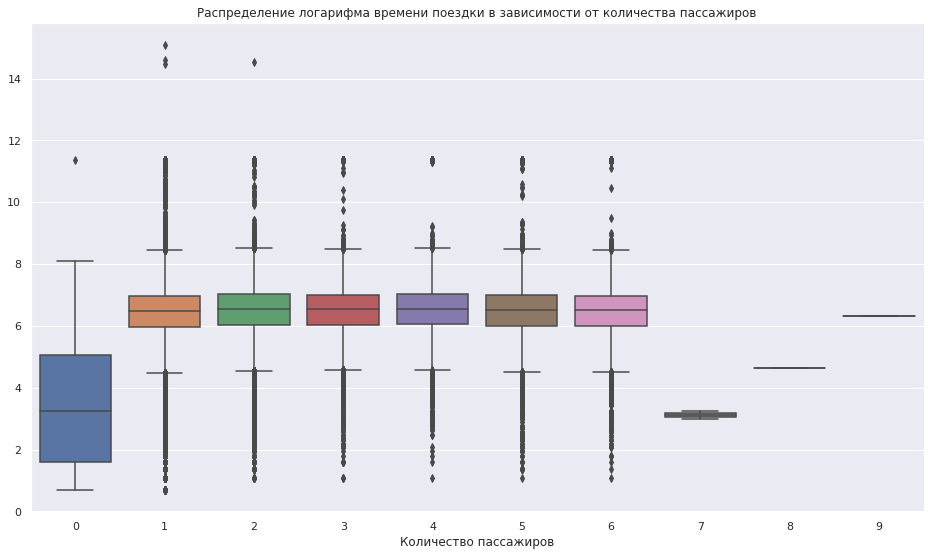

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x=X_train['passenger_count'], y=y_train)
plt.title(
    'Распределение логарифма времени поездки в зависимости от количества пассажиров'
)
plt.xlabel('Количество пассажиров')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
X_train['vendor_id'] = X_train['vendor_id'] - 1
X_test['vendor_id'] = X_test['vendor_id'] - 1

X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].map({
    'Y': 1,
    'N': 0
})
X_test['store_and_fwd_flag'] = X_test['store_and_fwd_flag'].map({
    'Y': 1,
    'N': 0
})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: По отдельности - нет (возможно - количество пассажиров), так как целевая переменная одинаковая для разных значений этих признаков

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
cat_features = [
    'pickup_hour', 'pickup_weekday', 'pickup', 'dropoff', 'pickup_month',
    'pickup_dayofyear'
]
bin_features = ([
    'is_anomal_1', 'is_anomal_2', 'is_free', 'jams',
    'started_in_kennedy_airport', 'ended_in_kennedy_airport',
    'started_in_liberty_airport', 'ended_in_liberty_airport',
    'store_and_fwd_flag', 'vendor_id'
])
num_features = ['log_haversine_distance', 'passenger_count']
features = cat_features + bin_features + num_features

In [ ]:
print(
    get_result(X_train, X_test, y_train, y_test, cat_features, num_features,
               features))

RMSE: 0.47201


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально 
маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

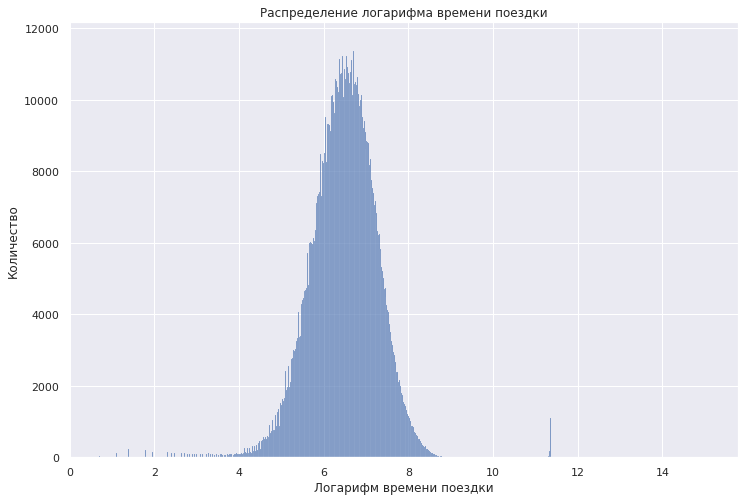

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(y_train)
plt.title('Распределение логарифма времени поездки')
plt.xlabel('Логарифм времени поездки')
plt.ylabel('Количество')
plt.show()

In [ ]:
# отбросили из тренировочной выборки объекты с аномально маленьким временем поездки
X_train_tmp = X_train[y_train > 2.5]
y_train_tmp = y_train[X_train_tmp.index]
print(
    get_result(X_train_tmp, X_test, y_train_tmp, y_test, cat_features,
               num_features, features))

RMSE: 0.47234


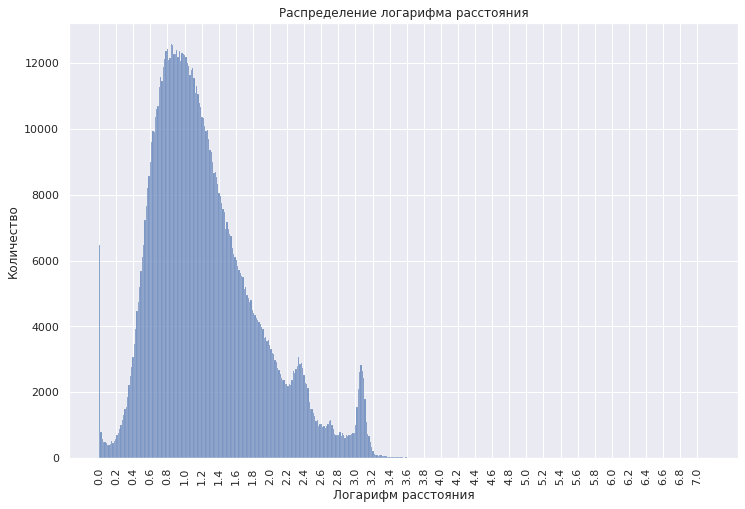

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(X_train['log_haversine_distance'])
plt.title('Распределение логарифма расстояния')
plt.xlabel('Логарифм расстояния')
plt.xticks(np.linspace(0, 7, 36), rotation='vertical')
plt.ylabel('Количество')
plt.show()

In [ ]:
# отбросили объекты с большим логарифмом расстояния
X_train_tmp = X_train[(X_train['log_haversine_distance'] < 3.3)]
y_train_tmp = y_train[X_train_tmp.index]
print(
    get_result(X_train_tmp, X_test, y_train_tmp, y_test, cat_features,
               num_features, features))

RMSE: 0.47201


In [ ]:
residiuals = np.zeros(len(y_train))
X_train_tmp = pd.get_dummies(X_train[features], columns=cat_features)
X_train_tmp[num_features] = scaler.fit_transform(X_train[num_features])
kf = KFold(5, shuffle=True, random_state=42)
for trn_idx, val_idx in kf.split(X_train_tmp, y_train):
    X_tr = X_train_tmp.iloc[trn_idx]
    X_te = X_train_tmp.iloc[val_idx]
    y_tr = y_train[trn_idx]
    y_te = y_train[val_idx]
    model = Ridge()
    model.fit(X_tr, y_tr)
    residiuals[val_idx] = np.abs(model.predict(X_te) - y_te)

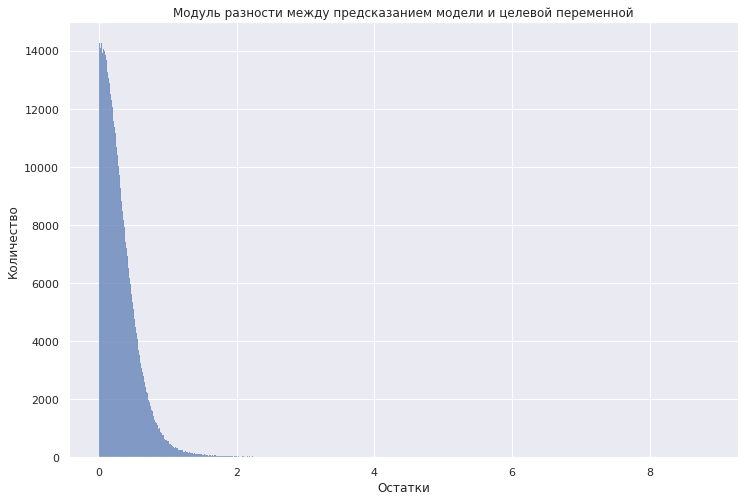

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(residiuals)
plt.title('Модуль разности между предсказанием модели и целевой переменной')
plt.xlabel('Остатки')
plt.ylabel('Количество')
plt.show()

In [ ]:
# отбросили из тренировочной выборки объекты, на которых модель ошибается сильнее всего
X_train_tmp = X_train.copy()
X_train_tmp['residiuals'] = residiuals
X_train_tmp = X_train_tmp[(X_train_tmp['residiuals'] < 2)]
y_train_tmp = y_train[X_train_tmp.index]
print(
    get_result(X_train_tmp, X_test, y_train_tmp, y_test, cat_features,
               num_features, features))

RMSE: 0.47217


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
X_train['pickup'].value_counts()

-1.0     141925
 21.0     88327
 27.0     77594
 20.0     70446
 14.0     66354
 28.0     65037
 15.0     61414
 22.0     58484
 35.0     56849
 8.0      51868
 29.0     42622
 33.0     37271
 9.0      36982
 1.0      30914
 13.0     29924
 7.0      22250
 26.0     19859
 34.0     14385
 36.0     12612
 19.0      8338
 2.0       6991
 16.0      5809
 5.0       2593
 23.0      1907
 24.0      1693
 3.0       1541
 30.0      1350
 25.0      1184
 11.0      1062
 32.0       809
 6.0        739
 4.0        571
 17.0       507
 10.0       448
 12.0       213
 18.0       168
 31.0        10
Name: pickup, dtype: int64

In [ ]:
X_train['dropoff'].value_counts()

-1.0     197572
 21.0     82678
 27.0     68832
 20.0     61306
 28.0     56335
 22.0     55974
 35.0     55361
 15.0     54987
 14.0     53990
 29.0     42545
 8.0      42039
 33.0     35761
 9.0      32544
 1.0      31140
 13.0     26159
 26.0     20782
 7.0      20413
 34.0     14412
 36.0     13640
 19.0     10504
 2.0       7699
 16.0      7612
 5.0       4261
 3.0       3318
 23.0      2920
 11.0      2698
 6.0       2228
 24.0      2181
 30.0      1864
 17.0      1773
 4.0       1741
 10.0      1732
 12.0      1297
 32.0      1243
 25.0      1176
 18.0       310
 31.0        23
Name: dropoff, dtype: int64

In [ ]:
class OneHotTopTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, category, treshold):
        self.treshold = treshold
        self.category = category
        self.top_cats = []

    def fit(self, df):
        self.top_cats = df[
            self.category].value_counts()[lambda x: x > self.treshold].index

    def transform(self, X):
        df = X.copy()
        df[self.category] = np.where(df[self.category].isin(self.top_cats),
                                     df[self.category], -2)
        return df

    def fit_transform(self, df):
        self.fit(df)
        df = self.transform(df)
        return df

In [ ]:
ohe_top = OneHotTopTransformer('pickup', 3000)
X_train_tmp = ohe_top.fit_transform(X_train)
X_test_tmp = ohe_top.transform(X_test)

In [ ]:
ohe_top = OneHotTopTransformer('dropoff', 3000)
X_train_tmp = ohe_top.fit_transform(X_train_tmp)
X_test_tmp = ohe_top.transform(X_test_tmp)

In [ ]:
print(
    get_result(X_train_tmp, X_test_tmp, y_train, y_test, cat_features,
               num_features, features))

RMSE: 0.47244


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [ ]:
X_train_tmp = X_train.copy()
X_train_tmp['residiuals'] = residiuals
X_train_tmp['target'] = y_train
X_train_tmp = X_train_tmp[(X_train_tmp['residiuals'] < 2)
                          & (X_train_tmp['target'] > 2.5) &
                          (X_train['log_haversine_distance'] < 3.3)]
y_train_tmp = X_train_tmp['target']
del X_train_tmp['target']

ohe_top = OneHotTopTransformer('pickup', 3000)
X_train_tmp = ohe_top.fit_transform(X_train_tmp)
X_test_tmp = ohe_top.transform(X_test)

ohe_top = OneHotTopTransformer('dropoff', 3000)
X_train_tmp = ohe_top.fit_transform(X_train_tmp)
X_test_tmp = ohe_top.transform(X_test_tmp)

print(
    get_result(X_train_tmp, X_test_tmp, y_train_tmp, y_test, cat_features,
               num_features, features))

RMSE: 0.47259


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
print(f"Количество признаков в датасете: {X_train.shape[1]}")
print(f"Количество признаков после OneHot-кодирования: {X_train_tmp.shape[1]}")

Количество признаков в датасете: 26
Количество признаков после OneHot-кодирования: 27


In [ ]:
def optimize(train, test, y_train, y_test, cat_features, num_features,
             features, model):
    train, test = preprocess(train, test, cat_features, num_features, features)
    model = model
    model.fit(train, y_train)
    preds = model.predict(test)
    err = mean_squared_error(y_test, preds, squared=False)
    null_weights = (model.coef_ == 0).sum()
    return np.round(err, 7), null_weights

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
err, _ = optimize(X_train,
                  X_test,
                  y_train,
                  y_test,
                  cat_features,
                  num_features,
                  features,
                  model=Lasso())
print(f"RMSE: {err}")

RMSE: 0.795027


Лучше оказалась Ridge- регрессия

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
trn_idx = len(X_train) // 10 * 8

X_tr = X_train[:trn_idx]
y_tr = y_train[:trn_idx]

X_val = X_train[trn_idx:]
y_val = y_train[trn_idx:]

In [ ]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10]
ridge_alpha = pd.Series(index=alphas, dtype=float)
for alpha in alphas:
    err, _ = optimize(X_tr,
                      X_val,
                      y_tr,
                      y_val,
                      cat_features,
                      num_features,
                      features,
                      model=Ridge(alpha=alpha))
    ridge_alpha[alpha] = err

In [ ]:
ridge_alpha

0.0001     0.471902
0.0010     0.471902
0.0100     0.471902
0.1000     0.471902
1.0000     0.471903
5.0000     0.471904
10.0000    0.471905
dtype: float64

In [ ]:
lasso_alpha = pd.Series(index=alphas, dtype=float)
null_count = pd.Series(index=alphas, dtype=float)
for alpha in alphas:
    err, nulls = optimize(X_tr,
                          X_val,
                          y_tr,
                          y_val,
                          cat_features,
                          num_features,
                          features,
                          model=Lasso(alpha=alpha))
    lasso_alpha[alpha] = err
    null_count[alpha] = nulls

In [ ]:
lasso_alpha

0.0001     0.472267
0.0010     0.476605
0.0100     0.500668
0.1000     0.536032
1.0000     0.797139
5.0000     0.797139
10.0000    0.797139
dtype: float64

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

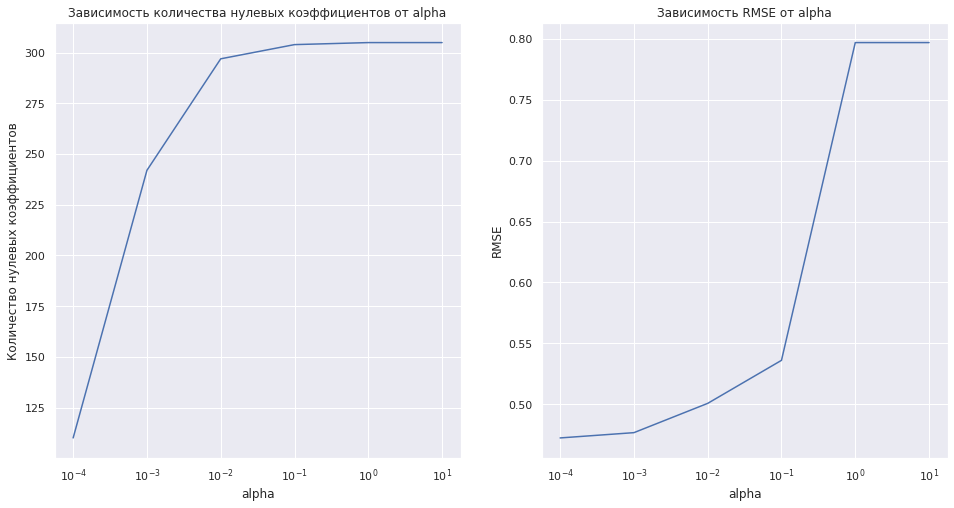

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(null_count.index, null_count)
ax[0].set_xscale('log')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('Количество нулевых коэффициентов')
ax[0].set_title('Зависимость количества нулевых коэффициентов от alpha')
ax[1].plot(lasso_alpha.index, lasso_alpha)
ax[1].set_xscale('log')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Зависимость RMSE от alpha')
plt.show()

После удаления 50% признаков потеряем в качестве примерно на уровне 3 знака после запятой

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: Поскольку взаимосвязь между этими признаками нелинейная. Может помочь для предсказания поездок, происходящих в центре города, у таких поездок небольшое расстояние между начальной и конечной точкой, следовательно, модель может лучше научиться предсказывать время непродолжительных поездок

In [ ]:
routes = X_train.groupby(['pickup', 'dropoff'], as_index=False)['id'].count()
routes = routes[(routes['pickup'] != -1) & (routes['dropoff'] != -1)]
routes = routes.sort_values(by=['id'], ascending=False).head(100)
routes

,pickup,dropoff,id
725,21.0,21.0,10093
1183,35.0,35.0,8710
688,20.0,21.0,8513
982,28.0,35.0,8227
724,21.0,20.0,8128
...,...,...,...
286,8.0,13.0,2553
675,20.0,8.0,2553
1112,33.0,35.0,2521
1219,36.0,35.0,2486


In [ ]:
X_train['route'] = -1
X_test['route'] = -1
for pickup, dropoff, ind in zip(routes['pickup'].values,
                                routes['dropoff'].values, range(1, 101)):
    X_train.loc[(X_train['pickup'] == pickup) &
                (X_train['dropoff'] == dropoff), 'route'] = ind
    X_test.loc[(X_test['pickup'] == pickup) & (X_test['dropoff'] == dropoff),
               'route'] = ind

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
cat_features = [
    'pickup_hour', 'pickup_weekday', 'pickup', 'dropoff', 'pickup_month',
    'pickup_dayofyear', 'route'
]
bin_features = ([
    'is_anomal_1', 'is_anomal_2', 'is_free', 'jams',
    'started_in_kennedy_airport', 'ended_in_kennedy_airport',
    'started_in_liberty_airport', 'ended_in_liberty_airport',
    'store_and_fwd_flag', 'vendor_id'
])
num_features = ['log_haversine_distance', 'passenger_count']
features = cat_features + bin_features + num_features

In [ ]:
print(
    get_result(X_train, X_test, y_train, y_test, cat_features, num_features,
               features))

RMSE: 0.46242


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.